## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

2023-09-27 10:51:41.575227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 10:51:42.349047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager
import warnings
import torch
from torch import nn as tnn
import captum
import torchvision
import wandb
from tqdm import tqdm
import os
import json
import time
import joblib

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/eMPRT/scripts/quantus/__init__.py
Using device: NVIDIA TITAN RTX


## Define Data and Model

In [3]:
class CifarLeNet(tnn.Module):
    """
    Small LeNet
    """
    def __init__(self, n_channels, n_outputs):
        super().__init__()
        
        # Feature extractor
        self.features = tnn.Sequential(
            tnn.Conv2d(n_channels, 16, 5),
            tnn.ReLU(),
            tnn.MaxPool2d(2, 2),
            tnn.Conv2d(16, 16, 5),
            tnn.ReLU(),
            tnn.MaxPool2d(2, 2),
        )

        # Classifier
        self.classifier = tnn.Sequential(
            tnn.Linear(400, 120), #tnn.Linear(400, 120) for Cifar10 #tnn.Linear(256, 120) for MNIST
            tnn.ReLU(),
            tnn.Dropout(),
            tnn.Linear(120, 84),
            tnn.ReLU(),
            tnn.Dropout(),
            tnn.Linear(84, n_outputs, bias=False),
        )

    def forward(self, x):
        """
        forwards input through network
        """

        # Forward through network
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # Return output
        return x

Preparing datasets...
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preparing dataloaders...


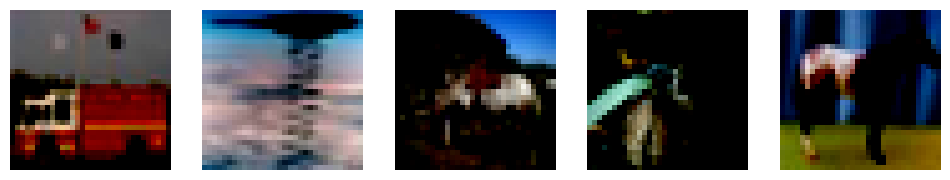

/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Load data.
DATASET_NAME = "cifar10"
NUM_CLASSES = 10
DATA_PATH = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/cifar10"
LR = 0.01
MODELCLASS = None #CifarLeNet
MODELNAME = "vgg16"

# Get Dataset
# Prepare transforms
transform = transforms.get_transforms(DATASET_NAME, mode="test")

# Prepare datasets
print("Preparing datasets...")
train_dataset = datasets.get_dataset(
    DATASET_NAME,
    DATA_PATH,
    transform,
    mode="train",
)

test_dataset = datasets.get_dataset(
    DATASET_NAME,
    DATA_PATH,
    transform,
    mode="test",
)

#print(f"Number of Samples in Train Dataset: {len(train_dataset.samples)}")
#print(f"Number of Samples in Test Dataset: {len(test_dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
train_loader = dataloaders.get_dataloader(
    dataset_name = DATASET_NAME,
    dataset = train_dataset,
    batch_size = 128,
    shuffle = True,
)
test_loader =  dataloaders.get_dataloader(
    dataset_name = DATASET_NAME,
    dataset = test_dataset,
    batch_size = 128,
    shuffle = False,
)

for i, (batch, labels) in enumerate(train_loader):

    x_batch = batch.numpy()

    img_size = x_batch.shape[2]
    nr_channels = x_batch.shape[1]

    # Plot the data!
    fix, ax = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(img_size, img_size, nr_channels))
        ax[i].axis("off")
    plt.show()

    break

# Prepare model
if MODELCLASS is not None:
    model = MODELCLASS(n_channels=nr_channels, n_outputs=NUM_CLASSES)
else:
    model = models.get_model(MODELNAME, device)
    if isinstance(model, torchvision.models.VGG) or isinstance(model, torchvision.models.AlexNet):
        classifier = list(model.classifier.children())
        model.classifier = torch.nn.Sequential(*classifier[:-1])
        model.classifier.add_module('last', torch.nn.Linear(classifier[-1].in_features, NUM_CLASSES))
    elif isinstance(model, torchvision.models.ResNet):
        classifier = model.fc
        model.fc = torch.nn.Linear(classifier.in_features, NUM_CLASSES)
model.to(device)
model.eval()

# Prepare Criterion
criterion = torch.nn.CrossEntropyLoss()

# Prepare Optimizer
optimizer = torch.optim.SGD(model.parameters(), LR ,momentum=0.9, weight_decay=5e-4)

# Prepare Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    """
    Trains Model.
    """


    # Set model to train mode
    model.train()


    running_loss = 0.0
    for i, (inputs, labels) in enumerate(loader):

        # Zero Optimizer
        optimizer.zero_grad()

        # Prepare inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Return labels, predictions, accuracy and loss
    return running_loss

def eval_epoch(model, loader, criterion, device):
    """
    Evaluates Model.
    """

    # Initialize running measures
    n_correct = 0
    n_predicted = 0
    total_labels = []
    total_predictions = []

    # Set model to eval mode
    model.eval()

    # Iterate over data. Show a progress bar.
    loss = 0
    #with tqdm(total=len(loader)) as pbar:
    for i, (inputs, labels) in enumerate(loader):

        # Prepare inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():

            outputs = model(inputs)

        loss += criterion(outputs, labels).cpu().detach().numpy()/ len(loader)

        # Check if binary or multi-class
        if outputs.shape[-1] == 1:
            preds = (outputs > 0).squeeze()
        else:
            preds = torch.argmax(outputs, dim=1)

        # Update accuracy counters
        n_correct += (preds == labels).float().sum()
        n_predicted += len(labels)

        # Update prediction lists
        for lab in labels.cpu().detach().numpy():
            total_labels.append(lab)
        for pred in preds.cpu().detach().numpy():
            total_predictions.append(pred)

    # Return labels, predictions, accuracy and loss
    return total_labels, total_predictions, (n_correct/n_predicted).cpu().detach().numpy(), loss

def eval_complexity(model, layers, loader, complexity_func, complexity_func_kwargs, device):
    """
    Evaluates Model Complexity.
    """

    # Set model to eval mode
    model.eval()

    complexities = {l: [] for l in layers}

    def hook(module, input, output):
        if not hasattr(module, "complexity"):
            module.complexity = []
        for o in output:
            module.complexity.append(complexity_func(o.detach().cpu().numpy(), None, **complexity_func_kwargs))

    def register_complexity_hooks(model):
        handles = []
        for l in model.named_modules():
            if (hasattr(l[1], "reset_parameters")):
                handles.append(l[1].register_forward_hook(hook))

        return handles
        
    handles = register_complexity_hooks(model)

    #with tqdm(total=len(loader)) as pbar:
    for i, (inputs, labels) in enumerate(loader):

        # Prepare inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

    for l in model.named_modules():
        if (hasattr(l[1], "reset_parameters")):
            complexities[l[0]] = l[1].complexity
            del l[1].complexity

    for handle in handles:
        handle.remove()

    # Return labels, predictions, accuracy and loss
    return complexities

## Train Model and Measure Complexity

In [6]:
complexity_func = quantus.complexity_func.discrete_entropy
complexity_func_kwargs = {"n_bins": 100}
n_epochs = 10
savepath = f"/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/train-{DATASET_NAME}-{MODELNAME}-complexity.joblib"
recompute=False

if not os.path.exists(savepath) or recompute:

    layers = [
            l[0]
            for l in model.named_modules()
            if (hasattr(l[1], "reset_parameters"))
        ]

    results = {
        "train_accuracy": [],
        "test_accuracy": [],
        "train_loss": [],
        "test_loss": [],
        "complexity": {
            l: [] for l in layers
        }
    }

    # Init Eval
    _, _, train_acc, train_loss = eval_epoch(model, train_loader, criterion, device)
    results["train_accuracy"].append(train_acc)
    results["train_loss"].append(train_loss)

    _, _, test_acc, test_loss = eval_epoch(model, test_loader, criterion, device)
    results["test_accuracy"].append(train_acc)
    results["test_loss"].append(train_loss)

    complexity = eval_complexity(model, layers, test_loader, complexity_func, complexity_func_kwargs, device)
    for lay in complexity.keys():
        results["complexity"][lay].append(np.mean(complexity[lay]))

    print(f"Init: Test Accuracy {test_acc}, Test Loss {test_loss}")

    # Train and eval epochs
    for epoch in range(n_epochs):

        t_loss = train_epoch(model, train_loader, optimizer, criterion, device)

        _, _, train_acc, train_loss = eval_epoch(model, train_loader, criterion, device)
        results["train_accuracy"].append(train_acc)
        results["train_loss"].append(train_loss)

        _, _, test_acc, test_loss = eval_epoch(model, test_loader, criterion, device)
        results["test_accuracy"].append(train_acc)
        results["test_loss"].append(train_loss)

        complexity = eval_complexity(model, layers, test_loader, complexity_func, complexity_func_kwargs, device)
        for lay in complexity.keys():
            results["complexity"][lay].append(np.mean(complexity[lay]))

        print(f"Epoch {epoch}: Test Accuracy {test_acc}, Test Loss {test_loss}")

        scheduler.step()

    joblib.dump(results, savepath)

else:
    results = joblib.load(savepath)

Init: Test Accuracy 0.10439999401569366, Test Loss 2.3981558854066876
Epoch 0: Test Accuracy 0.838699996471405, Test Loss 0.48554823519308354
Epoch 1: Test Accuracy 0.8513999581336975, Test Loss 0.4665190019185031
Epoch 2: Test Accuracy 0.8673999905586243, Test Loss 0.41071403441549853
Epoch 3: Test Accuracy 0.870199978351593, Test Loss 0.44315357864657534
Epoch 4: Test Accuracy 0.8822000026702881, Test Loss 0.4225190098904357
Epoch 5: Test Accuracy 0.8675000071525574, Test Loss 0.465005878406235
Epoch 6: Test Accuracy 0.8827999830245972, Test Loss 0.44225578613673605
Epoch 7: Test Accuracy 0.8757999539375305, Test Loss 0.49724652174907397
Epoch 8: Test Accuracy 0.887999951839447, Test Loss 0.43618864405758784
Epoch 9: Test Accuracy 0.8744999766349792, Test Loss 0.4811195203020605


## Plot

In [7]:
# General Plot Config
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams.update({'font.size': 15})
palette = cm.get_cmap("tab20")(np.linspace(0, 1, 20))
std_alpha = 0.2
linewidth = 2.5

/tmp/ipykernel_1722423/2273346928.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab20")(np.linspace(0, 1, 20))


/tmp/ipykernel_1722423/2691471102.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


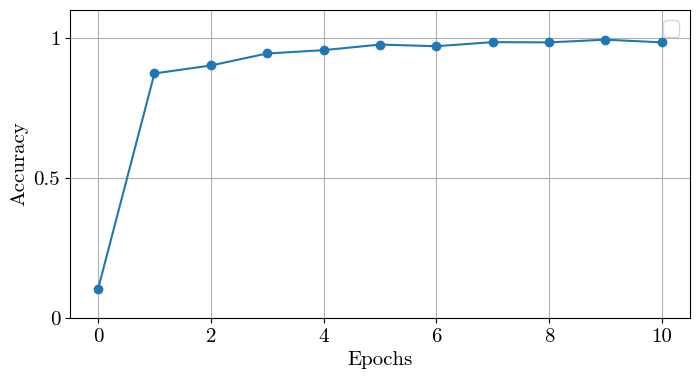

In [8]:
# Accuracy

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_ylabel("Accuracy")
ax.set_ylim([0.0, 1.1])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1])

ax.set_xlabel("Epochs")
ax.plot(results["test_accuracy"], marker="o")

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1722423/1293676572.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


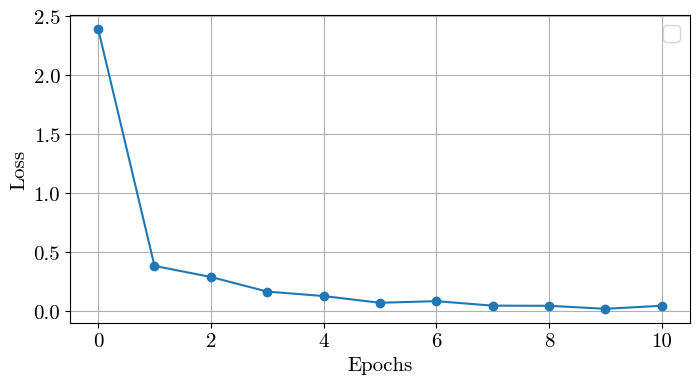

In [9]:
# Loss

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

ax.plot(results["test_loss"], marker="o")

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1722423/3233285666.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig1, ax1 = plt.subplots(1, 1, figsize=(8, 4))
/tmp/ipykernel_1722423/3233285666.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
/tmp/ipykernel_1722423/3233285666.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig3, ax3 = plt.subplots(1, 1, figsize=(8, 4))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


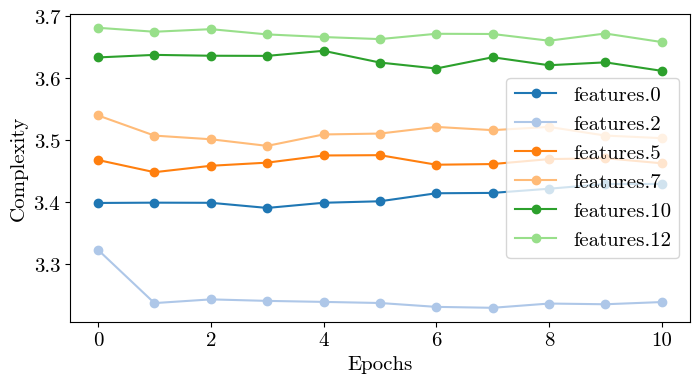

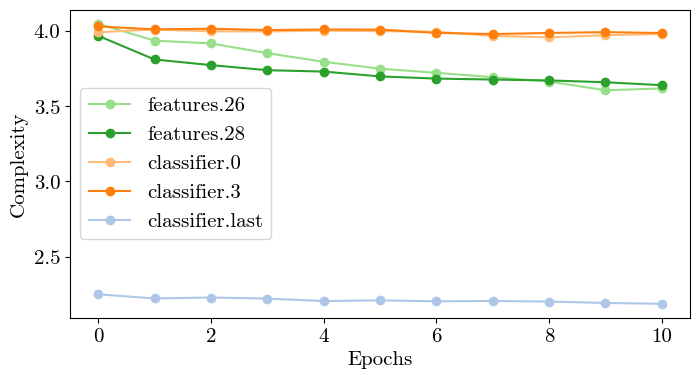

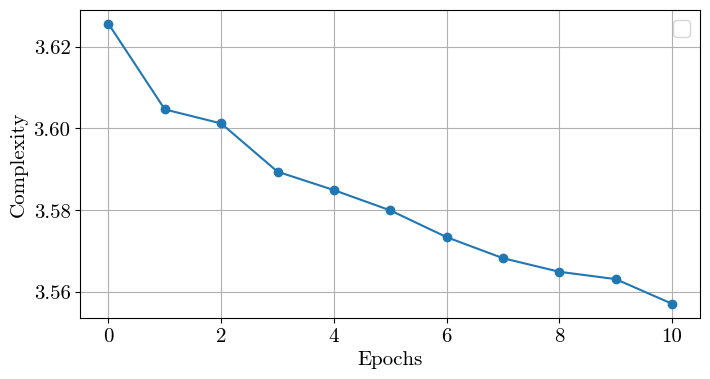

In [10]:
# Complexity

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 4))

ax1.set_ylabel("Complexity")
ax1.set_xlabel("Epochs")

ax2.set_ylabel("Complexity")
ax2.set_xlabel("Epochs")

ax3.set_ylabel("Complexity")
ax3.set_xlabel("Epochs")

compl = []
for l, lay in enumerate(results["complexity"].keys()):
    compl.append(results["complexity"][lay])
    
    if l <= 5:
        ax1.plot(results["complexity"][lay], marker="o", color=palette[l], label=lay)

    if l >= len(list(results["complexity"].keys()))-5:
        ax2.plot(results["complexity"][lay], marker="o", color=palette[len(list(results["complexity"].keys()))-l], label=lay)

ax3.plot(np.mean(compl, axis=0), marker="o")

ax1.legend()
ax2.legend()
ax3.legend()
plt.grid(True)
plt.show()